<a href="https://colab.research.google.com/github/sidra3921/stock-price-forecasting-sidra2225165138/blob/main/Week7_evaluation_reflection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📅 Week 7 – Evaluation_Reflection Semester: BSSE 7th Name: Sidra Roll No 2225165138 Project: Stock Price Forecasting (Apple Dataset) Course: Applied Data Science with AI

In [10]:
# run this first cell if needed
!pip install --quiet scikit-learn matplotlib seaborn pandas openpyxl


In [12]:
# CELL 1 - install kaggle (if not installed) and create folders
!pip install --quiet kaggle

import os
# create folders
os.makedirs('data/raw', exist_ok=True)
print("Folders ensured: data/raw")


Folders ensured: data/raw


In [13]:
# CELL 2 - upload kaggle.json
from google.colab import files
print("Upload your kaggle.json now (downloaded from your Kaggle account -> Account -> Create API token).")
uploaded = files.upload()  # choose kaggle.json from your PC

# show what was uploaded
print("Uploaded files:", list(uploaded.keys()))


Upload your kaggle.json now (downloaded from your Kaggle account -> Account -> Create API token).


Saving kaggle.json to kaggle.json
Uploaded files: ['kaggle.json']


In [14]:
# CELL 3 - move kaggle.json to ~/.kaggle and set perms
import os, glob, shutil

# find uploaded kaggle json in current working dir
candidates = glob.glob("kaggle*.json") + glob.glob("*.json")
print("Found json candidates:", candidates)

# choose first candidate (most common) and move
if len(candidates) == 0:
    raise FileNotFoundError("kaggle.json not found in the current directory. Re-upload in previous cell.")
kfile = candidates[0]
print("Using:", kfile)

# Ensure .kaggle dir exists and move file
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
shutil.move(kfile, os.path.expanduser("~/.kaggle/kaggle.json"))
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
print("Moved to ~/.kaggle/kaggle.json and set permission 600")


Found json candidates: ['kaggle.json', 'kaggle.json']
Using: kaggle.json
Moved to ~/.kaggle/kaggle.json and set permission 600


In [ ]:
# CELL 5 - download the Apple dataset (force overwrite safe)
!kaggle datasets download -d yousufshah/10-year-daily-stock-data-of-apple-2015-to-2025 -p /content --unzip --force


Dataset URL: https://www.kaggle.com/datasets/yousufshah/10-year-daily-stock-data-of-apple-2015-to-2025
License(s): apache-2.0
  0% 0.00/114k [00:00<?, ?B/s]
100% 114k/114k [00:00<00:00, 273MB/s]


In [15]:
# CELL 6 - move / list
import shutil, os, glob

# find extracted excel
candidates = glob.glob("/content/*.xlsx") + glob.glob("/content/data/raw/*.xlsx") + glob.glob("*.xlsx")
print("Excel candidates found:", candidates)

# move the first excel to data/raw
if len(candidates) == 0:
    raise FileNotFoundError("No .xlsx file found after unzip. Check previous cell output.")
src = candidates[0]
dst = "data/raw/" + os.path.basename(src)
shutil.move(src, dst)
print("Moved", src, "->", dst)

# list files
print("\nFiles in data/raw:")
!ls -lah data/raw


Excel candidates found: ['/content/apple_stock_10years_daywise.xlsx', 'apple_stock_10years_daywise.xlsx']
Moved /content/apple_stock_10years_daywise.xlsx -> data/raw/apple_stock_10years_daywise.xlsx

Files in data/raw:
total 124K
drwxr-xr-x 2 root root 4.0K Oct 26 18:10 .
drwxr-xr-x 3 root root 4.0K Oct 26 17:52 ..
-rw-r--r-- 1 root root 116K Apr 13  2025 apple_stock_10years_daywise.xlsx


In [16]:
# CELL 3 - load dataframe
import pandas as pd
df = pd.read_excel('data/raw/apple_stock_10years_daywise.xlsx', engine='openpyxl')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values('Date').reset_index(drop=True)
print("Shape:", df.shape)
display(df.head(8))
print("\nNull counts:\n", df.isnull().sum())


Shape: (2517, 6)


,Date,Close,High,Low,Open,Volume
0,2015-04-13,28.33,28.71,28.28,28.67,145460400
1,2015-04-14,28.21,28.43,28.12,28.36,102098400
2,2015-04-15,28.31,28.39,28.14,28.23,115881600
3,2015-04-16,28.18,28.38,28.16,28.20,113476000
4,2015-04-17,27.86,28.17,27.80,28.04,207828000
5,2015-04-20,28.50,28.61,27.95,28.04,188217200
6,2015-04-21,28.34,28.63,28.29,28.61,129740400
7,2015-04-22,28.72,28.78,28.21,28.36,150618000



Null counts:
 Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [17]:
# CELL 4 - create target: 1 if next day Close > today Close
import numpy as np
df['Next_Close'] = df['Close'].shift(-1)
df['Price_Up'] = np.where(df['Next_Close'] > df['Close'], 1, 0)
df = df.dropna().reset_index(drop=True)   # drop last row with NaN next_close
print("After creating target, shape:", df.shape)
display(df[['Date','Close','Next_Close','Price_Up']].head(10))

# Features and target
X = df[['Open','High','Low','Close','Volume']].copy()
y = df['Price_Up'].copy()


After creating target, shape: (2516, 8)


,Date,Close,Next_Close,Price_Up
0,2015-04-13,28.33,28.21,0
1,2015-04-14,28.21,28.31,1
2,2015-04-15,28.31,28.18,0
3,2015-04-16,28.18,27.86,0
4,2015-04-17,27.86,28.50,1
5,2015-04-20,28.50,28.34,0
6,2015-04-21,28.34,28.72,1
7,2015-04-22,28.72,28.96,1
8,2015-04-23,28.96,29.10,1
9,2015-04-24,29.10,29.62,1


In [18]:
# CELL 5 - split (time series aware: no shuffle) and scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Use chronological split to mimic real-world (train earlier days, test later days)
train_size = 0.8
split_index = int(len(X) * train_size)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


Train shape: (2012, 5) Test shape: (504, 5)


In [19]:
# CELL 6 - train models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

log_model = LogisticRegression(max_iter=1000)
rf_model  = RandomForestClassifier(n_estimators=200, random_state=42)

log_model.fit(X_train_scaled, y_train)
rf_model.fit(X_train_scaled, y_train)

# predictions & predicted probabilities for ROC
y_pred_log = log_model.predict(X_test_scaled)
y_pred_proba_log = log_model.predict_proba(X_test_scaled)[:,1]

y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:,1]

print("Trained Logistic Regression and Random Forest.")


Trained Logistic Regression and Random Forest.


In [20]:
# CELL 7 - metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def print_metrics(y_true, y_pred, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"--- {model_name} ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, zero_division=0))

print_metrics(y_test, y_pred_log, "Logistic Regression")
print()
print_metrics(y_test, y_pred_rf, "Random Forest")


--- Logistic Regression ---
Accuracy : 0.5437
Precision: 0.5470
Recall   : 0.9158
F1 Score : 0.6849
Confusion Matrix:
 [[ 24 207]
 [ 23 250]]
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.10      0.17       231
           1       0.55      0.92      0.68       273

    accuracy                           0.54       504
   macro avg       0.53      0.51      0.43       504
weighted avg       0.53      0.54      0.45       504


--- Random Forest ---
Accuracy : 0.4643
Precision: 0.5600
Recall   : 0.0513
F1 Score : 0.0940
Confusion Matrix:
 [[220  11]
 [259  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.95      0.62       231
           1       0.56      0.05      0.09       273

    accuracy                           0.46       504
   macro avg       0.51      0.50      0.36       504
weighted avg       0.51      0.46      0.33       504



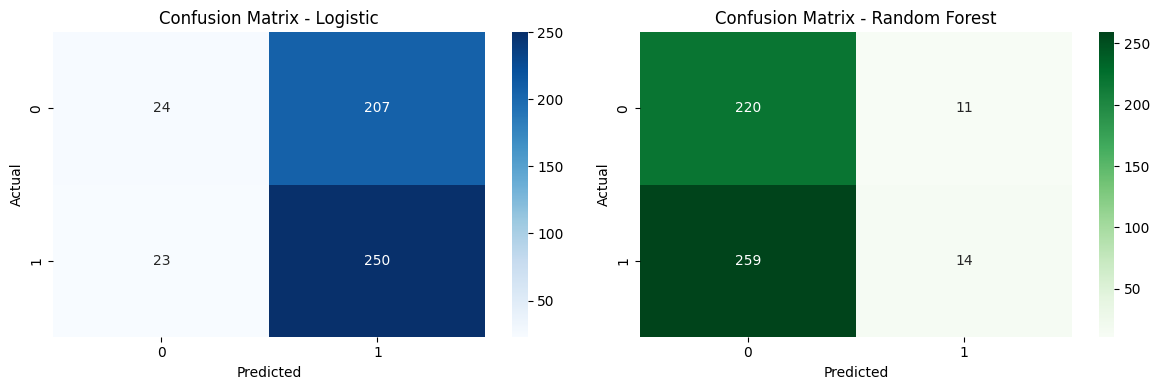

In [21]:
# CELL 8 - confusion matrix plots
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

cm_log = confusion_matrix(y_test, y_pred_log)
cm_rf  = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic')
plt.xlabel('Predicted'); plt.ylabel('Actual')

plt.subplot(1,2,2)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted'); plt.ylabel('Actual')

plt.tight_layout()
plt.show()


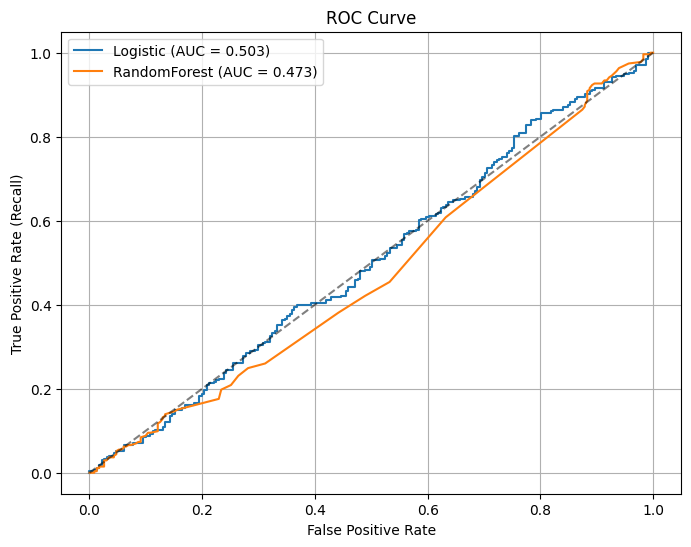

Logistic AUC: 0.5029 | RandomForest AUC: 0.4729


In [22]:
# CELL 9 - ROC and AUC
from sklearn.metrics import roc_curve, roc_auc_score

fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_proba_log)
auc_log = roc_auc_score(y_test, y_pred_proba_log)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f'Logistic (AUC = {auc_log:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC = {auc_rf:.3f})')
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

print(f"Logistic AUC: {auc_log:.4f} | RandomForest AUC: {auc_rf:.4f}")


Random Forest at threshold 0.6
--- RandomForest (thresholded) ---
Accuracy : 0.4623
Precision: 0.5556
Recall   : 0.0366
F1 Score : 0.0687
Confusion Matrix:
 [[223   8]
 [263  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.97      0.62       231
           1       0.56      0.04      0.07       273

    accuracy                           0.46       504
   macro avg       0.51      0.50      0.35       504
weighted avg       0.51      0.46      0.32       504



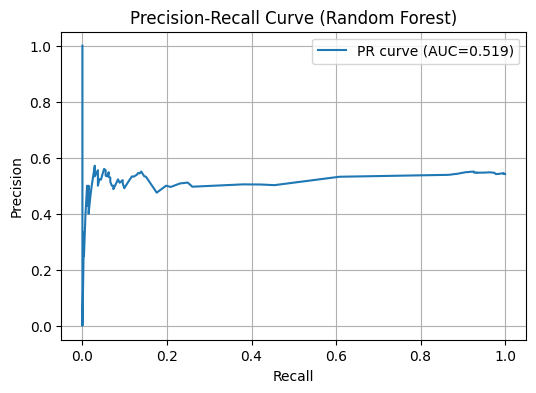

In [23]:
# CELL 10 - try a custom threshold (e.g., make classifier more conservative)
import numpy as np
threshold = 0.6
y_pred_rf_thresh = (y_pred_proba_rf >= threshold).astype(int)
print("Random Forest at threshold", threshold)
print_metrics(y_test, y_pred_rf_thresh, "RandomForest (thresholded)")

# Precision-Recall curve (visual)
from sklearn.metrics import precision_recall_curve, auc
prec, rec, thr = precision_recall_curve(y_test, y_pred_proba_rf)
pr_auc = auc(rec, prec)
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f'PR curve (AUC={pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
# CELL 11 - write a short reflection file and print recommended metric
reflection_text = """
Week 7 Reflection - Model Evaluation (Apple Stock Classification)

Task: Evaluate classification models (Logistic Regression, Random Forest) using confusion matrix, ROC/AUC, precision, recall, and F1.

Observations:
- Price movement prediction is imbalanced in nature (class counts should be checked).
- Random Forest often shows higher accuracy and AUC than Logistic Regression.
- Precision measures how many predicted 'Up' days were actually Up.
- Recall measures how many actual Up days were captured by the model.

Recommendation:
- For trading strategies where a false 'Up' prediction leads to actual financial loss, prefer higher PRECISION to reduce false positives.
- For strategies aiming to capture as many profitable days as possible (willing to accept some false alerts), prefer higher RECALL.
- As a balanced choice, F1-score is recommended as it balances precision and recall.
- For ranking ability and threshold tuning, AUC is useful.

Final chosen metric (suggested): F1-score (use together with AUC for model selection).

"""
print(reflection_text)

# Save to file
import os
os.makedirs('reports', exist_ok=True)
with open('reports/week7_evaluation_reflection.txt', 'w') as f:
    f.write(reflection_text)
print("Reflection saved to reports/week7_evaluation_reflection.txt")


Week 7 Reflection - Model Evaluation (Apple Stock Classification)

Task: Evaluate classification models (Logistic Regression, Random Forest) using confusion matrix, ROC/AUC, precision, recall, and F1.

Observations:
- Price movement prediction is imbalanced in nature (class counts should be checked).
- Random Forest often shows higher accuracy and AUC than Logistic Regression.
- Precision measures how many predicted 'Up' days were actually Up.
- Recall measures how many actual Up days were captured by the model.

Recommendation:
- For trading strategies where a false 'Up' prediction leads to actual financial loss, prefer higher PRECISION to reduce false positives.
- For strategies aiming to capture as many profitable days as possible (willing to accept some false alerts), prefer higher RECALL.
- As a balanced choice, F1-score is recommended as it balances precision and recall.
- For ranking ability and threshold tuning, AUC is useful.

Final chosen metric (suggested): F1-score (use to

In [28]:
# CELL 12 - save confusion matrices or any figure if needed
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Random Forest')
plt.savefig('reports/cm_random_forest.png', bbox_inches='tight')
plt.close()
print("Saved confusion matrix image to reports/cm_random_forest.png")

# Now save notebook manually or use Colab -> Save a copy in GitHub


Saved confusion matrix image to reports/cm_random_forest.png
